In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import itertools

In [2]:
# Load dataset
def load_data():
    """Load and preprocess the dataset."""

    df = pd.read_csv("hf://datasets/misikoff/SPX/^SPX.csv")
    df['Date'] = pd.to_datetime(df['Date'])

    df['Date_Original'] = df['Date']
    df.set_index('Date', inplace=True)
    df = df.sort_index()

    df = df[['Date_Original', 'Close']]
    return df

In [3]:
# Perform EDA and Handle Missing Data
def perform_eda(df):
    """Perform exploratory data analysis on the dataset."""

    print("Dataset Overview:\n", df.head())
    print("\n\nSummary Statistics:\n", df.describe())

    # Plot Closing Price over Time
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Close'], label='Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('SPX Closing Price Over Time')
    plt.legend()
    plt.show()

    return df

In [4]:
# Train-Test Split
def train_test_split(df, test_ratio=0.2):
    """Split the dataset into training and testing sets."""

    split_idx = int(len(df) * (1 - test_ratio))
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    return train_df, test_df

In [5]:
# Prepare Data for PyTorch
def prepare_data(df, seq_length=50, scaler=None, fit=True):
    """Prepare data for PyTorch model."""

    if scaler is None:
        scaler = MinMaxScaler()

    if fit:
        data_scaled = scaler.fit_transform(df[['Close']])
    else:
        data_scaled = scaler.transform(df[['Close']])

    # Create sequences
    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i+seq_length])
        y.append(data_scaled[i+seq_length])
    
    # Convert to tensors
    X, y = np.array(X), np.array(y)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader for batching
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=32, shuffle=False), scaler

In [6]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2):
        """Initialize LSTM model."""
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        """Forward pass for the model."""
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# Train Model
def train_model(model, train_loader, num_epochs=30, lr=0.001, device='cpu'):
    """Train the RNN model."""

    criterion = nn.MSELoss() # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam Optimizer
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)
    epoch_losses = []
    best_loss = float('inf')
    patience_counter = 0
    patience_limit = 15

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0  # Initialize total loss for the epoch

        # Iterate over batches
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(X_batch)
            # Compute loss
            loss = criterion(outputs, y_batch)
            # Backward pass and optimization
            loss.backward()
            # Update weights
            optimizer.step()
            total_loss += loss.item()  # Accumulate batch loss

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break
        scheduler.step(avg_loss)

    # Plot training loss
    plt.figure()
    plt.plot(epoch_losses)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [20]:
def evaluate_model(model, test_loader, scaler, device='cpu'):
    """Evaluate the model on the test set."""

    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())

    predictions = np.concatenate(predictions).reshape(-1, 1)
    actuals = np.concatenate(actuals).reshape(-1, 1)

    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)

    mse = np.mean((predictions - actuals) ** 2)
    mae = np.mean(np.abs(predictions - actuals))
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Closing Prices on Test Set')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [16]:
def hyperparameter_tuning(train_df, device = 'cpu'):
    """Tune hyperparameters for the model."""

    param_grid = {
        'hidden_size': [256, 512],
        'num_layers': [1, 2],
        'dropout': [0.3, 0.5],
        'lr': [1e-3, 5e-4, 1e-4],
        'seq_length': [50, 70]
    }

    best_loss = float('inf')
    best_params = None

    # Split the training data into a smaller training set and validation set
    train_sub, val_sub = train_test_split(train_df, test_ratio=0.2)

    # Iterate over all combinations of hyperparameters
    for hidden_size, num_layers, dropout, lr, seq_length in itertools.product(
        param_grid['hidden_size'], param_grid['num_layers'],
        param_grid['dropout'], param_grid['lr'], param_grid['seq_length']
    ):
        print(f"Trying config: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}, seq_length={seq_length}")
        train_loader, scaler = prepare_data(train_sub, seq_length, fit=True)
        val_loader, _ = prepare_data(val_sub, seq_length, scaler=scaler, fit=False)

        model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(10):  # Short training during tuning
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        avg_loss = val_loss / len(val_loader)
        print(f"Avg Validation Loss: {avg_loss:.4f}")

        # Check if this is the best configuration
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = (hidden_size, num_layers, dropout, lr, seq_length)

    print("\nBest config:")
    print(f"hidden_size={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, lr={best_params[3]}, seq_length={best_params[4]}")
    # Return the best parameters
    return best_params

Using device: cuda
Dataset Overview:
            Date_Original      Close
Date                               
1927-12-30    1927-12-30  17.660000
1928-01-03    1928-01-03  17.760000
1928-01-04    1928-01-04  17.719999
1928-01-05    1928-01-05  17.549999
1928-01-06    1928-01-06  17.660000


Summary Statistics:
                        Date_Original         Close
count                          24167  24167.000000
mean   1976-03-09 19:45:41.374601728    617.896353
min              1927-12-30 00:00:00      4.400000
25%              1952-03-11 12:00:00     24.590000
50%              1976-04-13 00:00:00    101.949997
75%              2000-03-09 12:00:00   1003.494995
max              2024-03-15 00:00:00   5175.270020
std                              NaN    993.672669


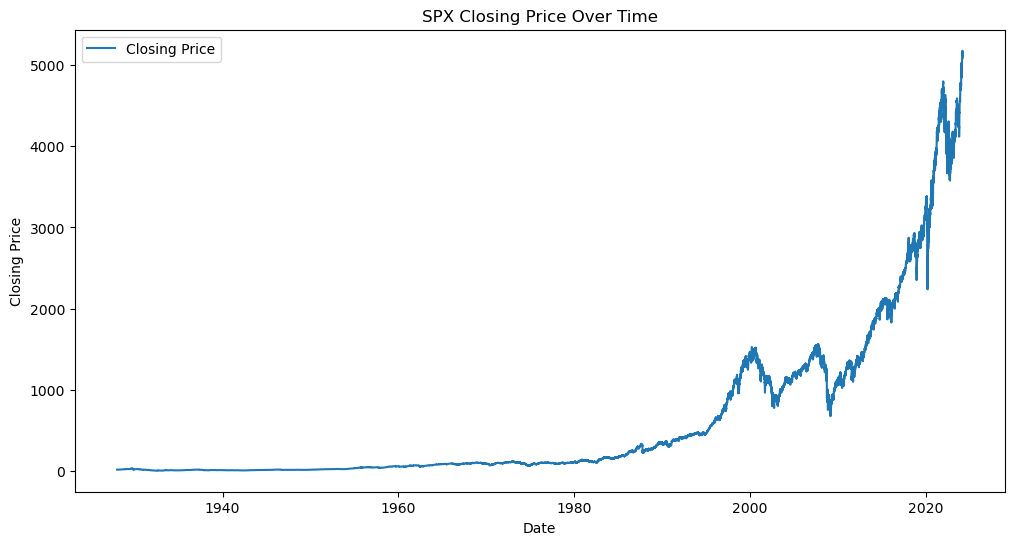

In [10]:
# Set device to use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
df = load_data()
df = perform_eda(df)
train_df, test_df = train_test_split(df)

In [17]:
# Hyperparameter tuning to find the best configuration
best_params = hyperparameter_tuning(train_df, device)

Trying config: hidden_size=256, num_layers=1, dropout=0.3, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.4728
Trying config: hidden_size=256, num_layers=1, dropout=0.3, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.4844
Trying config: hidden_size=256, num_layers=1, dropout=0.3, lr=0.0005, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.3316
Trying config: hidden_size=256, num_layers=1, dropout=0.3, lr=0.0005, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.3519
Trying config: hidden_size=256, num_layers=1, dropout=0.3, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.1498
Trying config: hidden_size=256, num_layers=1, dropout=0.3, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0962
Trying config: hidden_size=256, num_layers=1, dropout=0.5, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.8572
Trying config: hidden_size=256, num_layers=1, dropout=0.5, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.7785
Trying config: hidden_size=256, num_layers=1, dropout=0.5, lr=0.0005, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.3995
Trying config: hidden_size=256, num_layers=1, dropout=0.5, lr=0.0005, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.4800
Trying config: hidden_size=256, num_layers=1, dropout=0.5, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0537
Trying config: hidden_size=256, num_layers=1, dropout=0.5, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0337
Trying config: hidden_size=256, num_layers=2, dropout=0.3, lr=0.001, seq_length=50
Avg Validation Loss: 3.8033
Trying config: hidden_size=256, num_layers=2, dropout=0.3, lr=0.001, seq_length=70
Avg Validation Loss: 3.9627
Trying config: hidden_size=256, num_layers=2, dropout=0.3, lr=0.0005, seq_length=50
Avg Validation Loss: 3.4025
Trying config: hidden_size=256, num_layers=2, dropout=0.3, lr=0.0005, seq_length=70
Avg Validation Loss: 3.2121
Trying config: hidden_size=256, num_layers=2, dropout=0.3, lr=0.0001, seq_length=50
Avg Validation Loss: 0.3549
Trying config: hidden_size=256, num_layers=2, dropout=0.3, lr=0.0001, seq_length=70
Avg Validation Loss: 0.1618
Trying config: hidden_size=256, num_layers=2, dropout=0.5, lr=0.001, seq_length=50
Avg Validation Loss: 3.5632
Trying config: hidden_size=256, num_layers=2, dropout=0.5, lr=0.001, seq_length=70
Avg Validation Loss: 5.2357
Trying config: hidden_size=256, num_layers=2, dropout=0.5, lr=0.0005, seq_length

/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.1817
Trying config: hidden_size=512, num_layers=1, dropout=0.3, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 2.9559
Trying config: hidden_size=512, num_layers=1, dropout=0.3, lr=0.0005, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 1.5479
Trying config: hidden_size=512, num_layers=1, dropout=0.3, lr=0.0005, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 1.2107
Trying config: hidden_size=512, num_layers=1, dropout=0.3, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0600
Trying config: hidden_size=512, num_layers=1, dropout=0.3, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0458
Trying config: hidden_size=512, num_layers=1, dropout=0.5, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 1.5622
Trying config: hidden_size=512, num_layers=1, dropout=0.5, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.1055
Trying config: hidden_size=512, num_layers=1, dropout=0.5, lr=0.0005, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 3.4250
Trying config: hidden_size=512, num_layers=1, dropout=0.5, lr=0.0005, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.6819
Trying config: hidden_size=512, num_layers=1, dropout=0.5, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0135
Trying config: hidden_size=512, num_layers=1, dropout=0.5, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Avg Validation Loss: 0.0429
Trying config: hidden_size=512, num_layers=2, dropout=0.3, lr=0.001, seq_length=50
Avg Validation Loss: 3.4538
Trying config: hidden_size=512, num_layers=2, dropout=0.3, lr=0.001, seq_length=70
Avg Validation Loss: 3.4164
Trying config: hidden_size=512, num_layers=2, dropout=0.3, lr=0.0005, seq_length=50
Avg Validation Loss: 3.2358
Trying config: hidden_size=512, num_layers=2, dropout=0.3, lr=0.0005, seq_length=70
Avg Validation Loss: 0.7603
Trying config: hidden_size=512, num_layers=2, dropout=0.3, lr=0.0001, seq_length=50
Avg Validation Loss: 0.0478
Trying config: hidden_size=512, num_layers=2, dropout=0.3, lr=0.0001, seq_length=70
Avg Validation Loss: 0.1588
Trying config: hidden_size=512, num_layers=2, dropout=0.5, lr=0.001, seq_length=50
Avg Validation Loss: 3.4460
Trying config: hidden_size=512, num_layers=2, dropout=0.5, lr=0.001, seq_length=70
Avg Validation Loss: 0.3254
Trying config: hidden_size=512, num_layers=2, dropout=0.5, lr=0.0005, seq_length

/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/home/jatinj/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Loss: 0.0008
Epoch [2/30], Loss: 0.0052
Epoch [3/30], Loss: 0.0064
Epoch [4/30], Loss: 0.0070
Epoch [5/30], Loss: 0.0049
Epoch [6/30], Loss: 0.0026
Epoch [7/30], Loss: 0.0011
Epoch [8/30], Loss: 0.0004
Epoch [9/30], Loss: 0.0001
Epoch [10/30], Loss: 0.0000
Epoch [11/30], Loss: 0.0000
Epoch [12/30], Loss: 0.0000
Epoch [13/30], Loss: 0.0000
Epoch [14/30], Loss: 0.0000
Epoch [15/30], Loss: 0.0000
Epoch [16/30], Loss: 0.0000
Epoch [17/30], Loss: 0.0000
Epoch [18/30], Loss: 0.0000
Epoch [19/30], Loss: 0.0000
Epoch [20/30], Loss: 0.0000
Epoch [21/30], Loss: 0.0000
Epoch [22/30], Loss: 0.0000
Epoch [23/30], Loss: 0.0000
Epoch [24/30], Loss: 0.0000
Epoch [25/30], Loss: 0.0000
Epoch [26/30], Loss: 0.0000
Epoch [27/30], Loss: 0.0000
Epoch [28/30], Loss: 0.0000
Epoch [29/30], Loss: 0.0000
Epoch [30/30], Loss: 0.0000


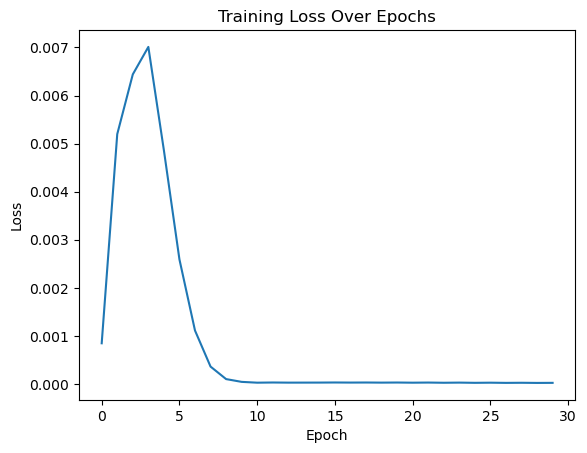


Model Type: Standard LSTM
Hidden Size: 512
Num Layers: 1
Dropout: 0.5
Learning Rate: 0.0001
Window Length: 50


In [18]:
# Train the model with the best parameters
train_loader, scaler = prepare_data(train_df, seq_length=best_params[4])
model = LSTMModel(hidden_size=best_params[0], num_layers=best_params[1], dropout=best_params[2]).to(device)
train_model(model, train_loader, lr=best_params[3], device=device)

print("\nModel Type: Standard LSTM")
print(f"Hidden Size: {best_params[0]}")
print(f"Num Layers: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Window Length: {best_params[4]}")


Model Type: Standard LSTM
Hidden Size: 512
Num Layers: 1
Dropout: 0.5
Test MSE: 206639.8750
Test MAE: 282.0965


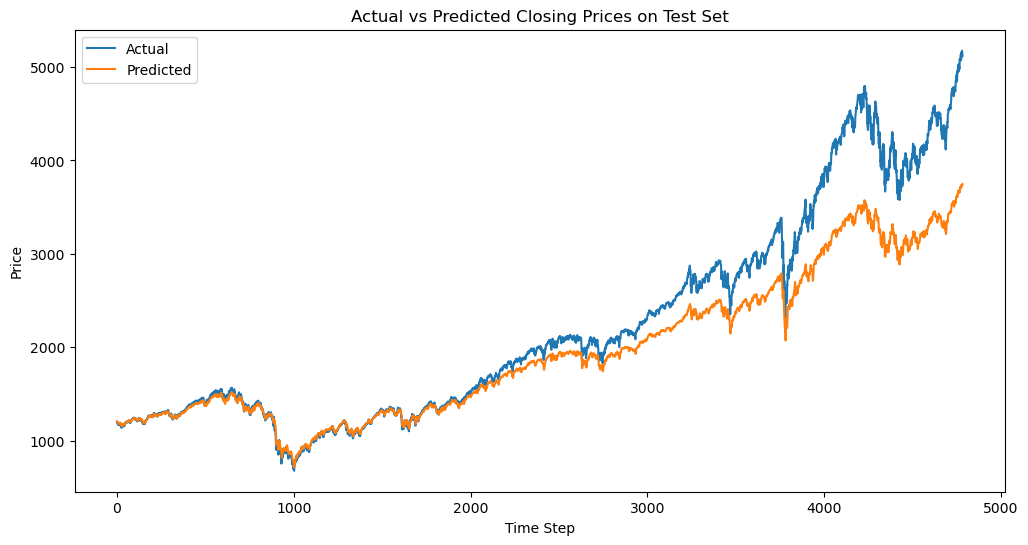

In [19]:
# Prepare test data for evaluation
test_loader, _ = prepare_data(test_df, seq_length=best_params[4], scaler=scaler, fit=False)
# Evaluate the model on the test set
evaluate_model(model, test_loader, scaler)